<a href="https://colab.research.google.com/github/alessandrobruni/tensorflow_intro/blob/main/C2_W2_Lab_2_horses_v_humans_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W2/ungraded_labs/C2_W2_Lab_2_horses_v_humans_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Data Augmentation on the Horses or Humans Dataset

In the previous lab, you saw how data augmentation helped improve the model's performance on unseen data. By tweaking the cat and dog training images, the model was able to learn features that are also representative of the validation data. However, applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results. 

In the next cells, you will apply the same techniques to the `Horses or Humans` dataset and analyze the results.

In [1]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2022-11-11 08:27:30--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   141MB/s    in 1.0s    

2022-11-11 08:27:31 (141 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [4]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2022-11-11 08:29:59--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.250.98.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘validation-horse-or-human.zip.2’

validation-horse-or 100%[===================>]  10.95M  --.-KB/s    in 0.1s    

2022-11-11 08:29:59 (80.4 MB/s) - ‘validation-horse-or-human.zip.2’ saved [11480187/11480187]



In [12]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
zip_ref.extractall('tmp/horse-or-human')

zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
zip_ref.extractall('tmp/validation-horse-or-human')

zip_ref.close()

# Directory with training horse pictures
train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('tmp/horse-or-human/humans')

# Directory with training horse pictures
validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# Directory with training human pictures
validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

In [5]:
import tensorflow as tf

# Build the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
from tensorflow.keras.optimizers import RMSprop

# Set training parameters
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'tmp/horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'tmp/validation-horse-or-human/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [15]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/20
8/8 [==============================] - 30s 2s/step - loss: 0.6893 - accuracy: 0.6140 - val_loss: 0.6669 - val_accuracy: 0.6250
Epoch 2/20
8/8 [==============================] - 21s 3s/step - loss: 0.6677 - accuracy: 0.6452 - val_loss: 0.7013 - val_accuracy: 0.5000
Epoch 3/20
8/8 [==============================] - 22s 3s/step - loss: 0.6376 - accuracy: 0.7030 - val_loss: 0.8001 - val_accuracy: 0.5000
Epoch 4/20
8/8 [==============================] - 22s 3s/step - loss: 0.6276 - accuracy: 0.6707 - val_loss: 0.7924 - val_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 21s 3s/step - loss: 0.5764 - accuracy: 0.7308 - val_loss: 0.4725 - val_accuracy: 0.9688
Epoch 6/20
8/8 [==============================] - 21s 3s/step - loss: 0.6018 - accuracy: 0.6952 - val_loss: 0.5502 - val_accuracy: 0.6562
Epoch 7/20
8/8 [==============================] - 21s 3s/step - loss: 0.5839 - accuracy: 0.7219 - val_loss: 0.5308 - val_accuracy: 0.6758
Epoch 8/20
8/8 [==================

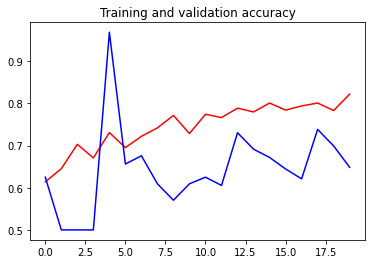

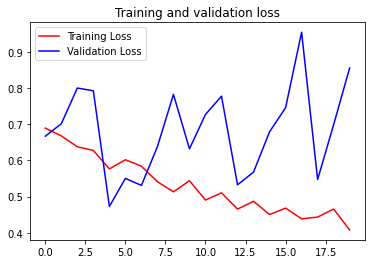

In [16]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))
  
  plt.grid(axis='y',)
  plt.ylim(ymin=0)
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')


  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.grid(axis='y')
  plt.ylim(ymin=0)

  plt.show()


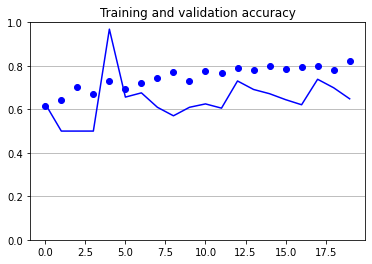

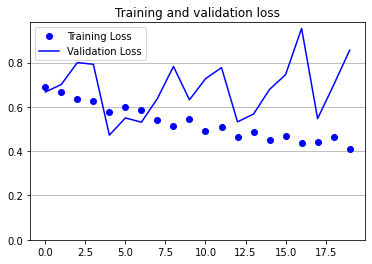

In [25]:
plot_loss_acc(history)

As you can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data generated still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the image processing techniques that `ImageDataGenerator` provides. It might also be that the background of the training images are also learned so the white background of the validation set is throwing the model off even with cropping. Try looking at the validation images in the `tmp/validation-horse-or-human` directory (note: if you are using Colab, you can use the file explorer on the left to explore the images) and see if you can augment the training images to match its characteristics. If this is not possible, then at this point you can consider other techniques and you will see that in next week's lessons.

TRAIN SET HORSES: ['horse13-1.png', 'horse45-7.png', 'horse29-5.png', 'horse24-6.png', 'horse12-9.png', 'horse15-6.png', 'horse23-2.png', 'horse14-8.png', 'horse11-2.png', 'horse32-9.png']
TRAIN SET HUMANS: ['human16-04.png', 'human06-22.png', 'human09-25.png', 'human13-05.png', 'human08-23.png', 'human01-01.png', 'human17-16.png', 'human12-23.png', 'human16-18.png', 'human09-29.png']
VAL SET HORSES: ['horse4-302.png', 'horse2-183.png', 'horse4-043.png', 'horse4-439.png', 'horse2-040.png', 'horse4-588.png', 'horse6-153.png', 'horse3-055.png', 'horse5-192.png', 'horse5-342.png']
VAL SET HUMANS: ['valhuman03-10.png', 'valhuman02-02.png', 'valhuman02-21.png', 'valhuman01-00.png', 'valhuman04-04.png', 'valhuman02-23.png', 'valhuman05-12.png', 'valhuman03-07.png', 'valhuman02-03.png', 'valhuman03-21.png']


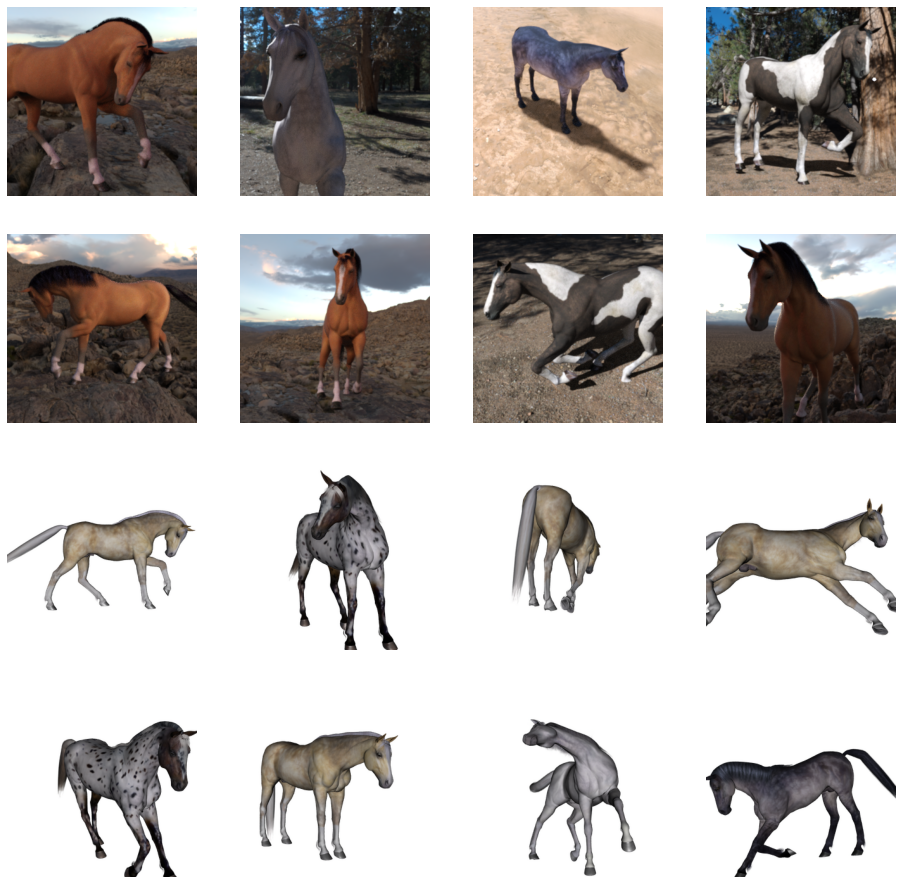

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_horse_names = os.listdir(train_horse_dir)
print(f'TRAIN SET HORSES: {train_horse_names[:10]}')

train_human_names = os.listdir(train_human_dir)
print(f'TRAIN SET HUMANS: {train_human_names[:10]}')

validation_horse_names = os.listdir(validation_horse_dir)
print(f'VAL SET HORSES: {validation_horse_names[:10]}')

validation_human_names = os.listdir(validation_human_dir)
print(f'VAL SET HUMANS: {validation_human_names[:10]}')

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(validation_horse_dir, fname) 
                for fname in validation_horse_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()
